# Flux limiters

Jupyter notebook to illustrate flux limiters and high-resolution schemes

Philipp Schlatter, January 2022

---

## Perliminaries

Initialisation of the libraries and graphics:

In [1]:
%matplotlib notebook 
# possible options: notebook, inline or widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.animation
from math import pi
params = {'legend.fontsize': 12,
          'legend.loc':'best',
          'figure.figsize': (8,5),
          'lines.markerfacecolor':'none',
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize':12,
          'ytick.labelsize':12,
          'grid.alpha':0.6}
pylab.rcParams.update(params)

Define grid and initial condition

In [2]:
L=10
T=15
nx=501
nt=1501
dx=L/(nx-1)    
dt=T/(nt-1)
x=np.linspace(0,L,num=nx,endpoint=True)
t=np.linspace(0,T,num=nt,endpoint=True)

u0=np.zeros(nx)
u0[np.logical_and(x>=1,x<2)]=1
u0[np.logical_and(x>=8,x<9)]=-1
u0[np.logical_and(x>=2,x<3)]=0
u0[np.logical_and(x>=3,x<4)]=2
'''
u0=np.zeros(nx)
for i in range(nx):
    if x[i]>=2 and x[i]<3:
        u0[i]=x[i]-2
    if x[i]>=3 and x[i]<=4:
        u0[i]=-x[i]+4
'''

'''
u0=np.zeros(nx)
u0[np.logical_and(x>=4,x<=5)]=-1
u0[np.logical_and(x>=5,x<=6)]=1


u0=np.zeros(nx)
u0[np.logical_and(x>=2,x<3)]=1
'''

'\nu0=np.zeros(nx)\nu0[np.logical_and(x>=4,x<=5)]=-1\nu0[np.logical_and(x>=5,x<=6)]=1\n\n\nu0=np.zeros(nx)\nu0[np.logical_and(x>=2,x<3)]=1\n'

<IPython.core.display.Javascript object>


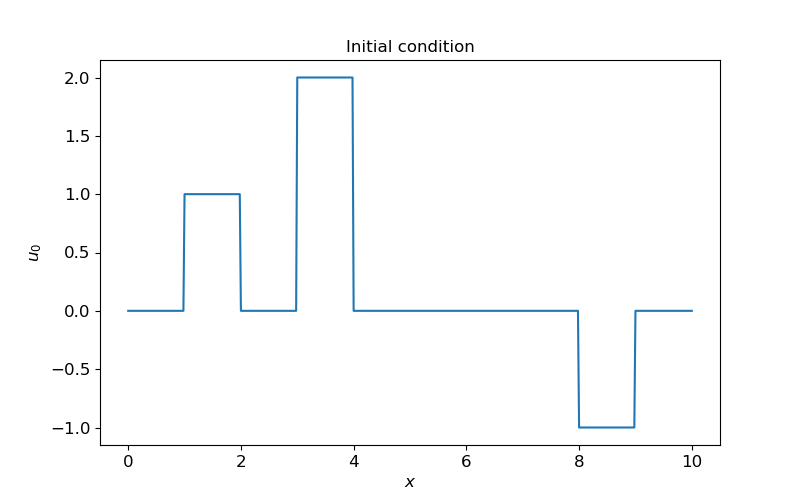

In [3]:
plt.figure()
plt.plot(x,u0)
plt.xlabel(r'$x$')
plt.ylabel(r'$u_0$')
plt.title('Initial condition')
plt.show()

Preallocate all necessary array variables:

In [4]:
u_lf = np.zeros( (nx,nt) )
u_lw = np.zeros( (nx,nt) )
u_fs = np.zeros( (nx,nt) )
u_fl = np.zeros( (nx,nt) )

up = np.zeros( nx )


fp = np.zeros(nx)
fm = np.zeros(nx)
phi = np.zeros(nx)
r  = np.zeros(nx)

u_lf[:,0] = u0
u_lw[:,0] = u0
u_fs[:,0] = u0
u_fl[:,0] = u0

Time integration:

In [5]:
j0=range(1,nx-1)
jm=[x-1 for x in j0]
jp=[x+1 for x in j0]

np.seterr(divide='ignore',invalid='ignore',over='ignore')
for i in range(nt-1):
    
    # Lax-Friedrichs
    f_lf_1 = 0.5*(u_lf[jm,i]**2/2+u_lf[j0,i]**2/2) - dx/2/dt*(u_lf[j0,i]-u_lf[jm,i])
    f_lf_2 = 0.5*(u_lf[j0,i]**2/2+u_lf[jp,i]**2/2) - dx/2/dt*(u_lf[jp,i]-u_lf[j0,i])
    u_lf[j0,i+1] = u_lf[j0,i] - dt/dx*(f_lf_2-f_lf_1)
    # u_lf[j0,i+1] = (u_lf[jp,i]+u_lf[jm,i])/2 - dt/2/dx*( u_lf[jp,i]**2/2-u_lf[jm,i]**2/2) 
    
    # 2nd order Lax-Wendroff (Richtmyer)
    up[j0] = 0.5*(u_lw[jp,i]+u_lw[j0,i])-dt/2/dx*(u_lw[jp,i]**2/2-u_lw[j0,i]**2/2)
    f_lw_1 = up[jm]**2/2
    f_lw_2 = up[j0]**2/2
    u_lw[j0,i+1] = u_lw[j0,i] - dt/dx*(f_lw_2-f_lw_1)    
      
    # upwind with flux splitting
    #
    #  Burgers flux: f=u^2/2, f'=u
    #
    #  Upwind: un+1=un - dt/dx*(f)
    #  fp = 0.5*(2u)*u*0.5 = 0.5*u^2
    #  fm = 0
    #  f_fs_1 = fpm
    #  f_fs_2 = fp0
    #  u_fs^i+1 = u_fs^i - dt/dx*(fp0-fpm) = u_fs^i - dt/dx*(  f0-fm )
    #  
    #
    fp[j0] = 0.5*(u_fs[j0,i]+abs(u_fs[j0,i]))*u_fs[j0,i]*0.5
    fm[j0] = 0.5*(u_fs[j0,i]-abs(u_fs[j0,i]))*u_fs[j0,i]*0.5
    
    # fp[j0] = np.maximum(u_fs[j0,i],0)*u_fs[j0,i]*0.5
    # fm[j0] = np.minimum(u_fs[j0,i],0)*u_fs[j0,i]*0.5
    
    f_fs_1  = fp[jm]+fm[j0]
    f_fs_2  = fp[j0]+fm[jp]
    u_fs[j0,i+1] = u_fs[j0,i] - dt/dx*(f_fs_2-f_fs_1)

    # Flux limiters
    r[j0]=(u_fl[j0,i]-u_fl[jm,i])/(u_fl[jp,i]-u_fl[j0,i])
    r[np.isnan(r)]=1
    r=np.minimum(r,100000)
    r=np.maximum(r,-100000)
    phi = (r+abs(r))/(1+abs(r))   # van Leer limiter
    
    # Lax-Wendroff for high order
    up[j0] = 0.5*(u_fl[jp,i]+u_fl[j0,i])-dt/2/dx*(u_fl[jp,i]**2/2-u_fl[j0,i]**2/2)
    f_high_1 = up[jm]**2/2
    f_high_2 = up[j0]**2/2
    # upwind with flux splitting for low order
    fp[j0] = 0.5*(u_fl[j0,i]+abs(u_fl[j0,i]))*u_fl[j0,i]*0.5
    fm[j0] = 0.5*(u_fl[j0,i]-abs(u_fl[j0,i]))*u_fl[j0,i]*0.5 
    f_low_1  = fp[jm]+fm[j0];
    f_low_2  = fp[j0]+fm[jp];
    # alternatively, take Lax-Friedrichs for low order    
    # f_low_1 = 0.5*(u_fl[jm,i]**2/2+u_fl[j0,i]**2/2) - dx/2/dt*(u_fl[j0,i]-u_fl[jm,i])
    # f_low_2 = 0.5*(u_fl[j0,i]**2/2+u_fl[jp,i]**2/2) - dx/2/dt*(u_fl[jp,i]-u_fl[j0,i])
 
    f_fl_1 = f_low_1-phi[jm]*(f_low_1-f_high_1)
    f_fl_2 = f_low_2-phi[j0]*(f_low_2-f_high_2)
    u_fl[j0,i+1] = u_fl[j0,i] - dt/dx*(f_fl_2-f_fl_1)

np.seterr(divide='warn',invalid='warn',over='warn');


Animated plotting:

<IPython.core.display.Javascript object>


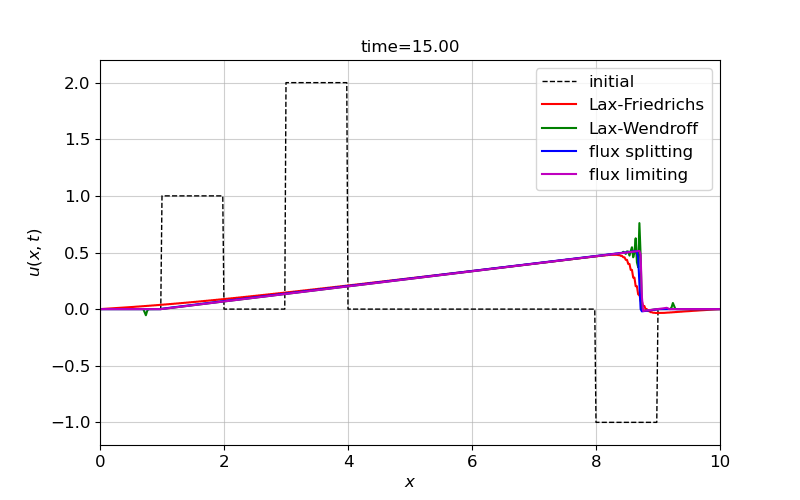

In [6]:
#plt.rcParams["animation.html"] = "jshtml"
#plt.ion()
scale = 25

fig = plt.figure(figsize=(8,5))

def animate(j):
    plt.cla()
    plt.xlabel(r'$x$')
    plt.ylabel(r'$u(x,t)$')
    plt.grid()
    plt.plot(x,u0,'k--',lw=1,label='initial')
    plt.plot(x,u_lf[:,scale*j],'r',label='Lax-Friedrichs')
    plt.plot(x,u_lw[:,scale*j],'g',label='Lax-Wendroff')
    plt.plot(x,u_fs[:,scale*j],'b',label='flux splitting')
    plt.plot(x,u_fl[:,scale*j],'m',label='flux limiting')
    plt.xlim(0,L)
    plt.ylim(-1.2,2.2)
    plt.title(f"time={t[scale*j]:.2f}")  
    plt.legend(loc='upper right')
    
ani=matplotlib.animation.FuncAnimation(fig, animate, frames=int((nt-1)/scale+1), repeat=False,interval=1)
#writer = matplotlib.animation.writers['ffmpeg']
#writer = writer(fps=24)
#ani.save('out.mp4', writer=writer)

We can now also show our solution as a so-called _space-time diagram_, where we can see the complete solution $u(x,t)$.

<IPython.core.display.Javascript object>


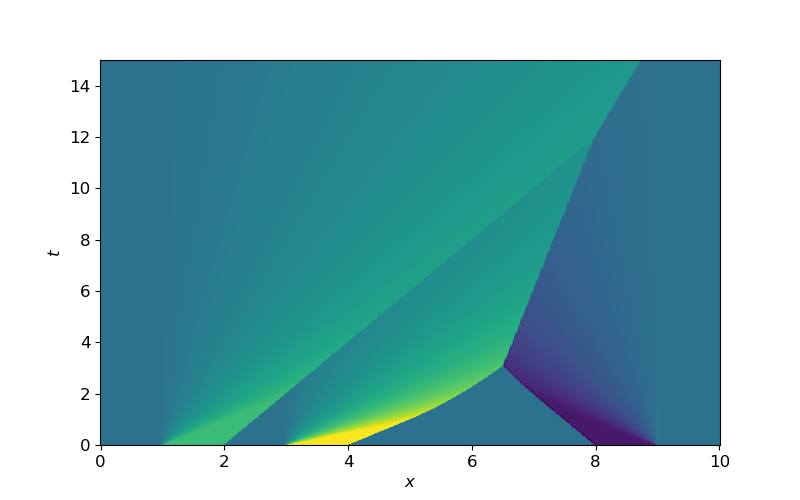

In [7]:
plt.figure()
plt.pcolor(x,t,u_fl.T,shading='nearest')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.show()

All cases are conservative since they are implemented using the conservative formulation of the underlying Burgers equation. Therefore, the integral (here we take for simplicity the trapezoidal rule) of the solution $u$ over the domain $0\leq x \leq L$ does not change:

In [8]:
(np.sum(u0)*dx,np.sum(u_fl[:,100])*dx)

(2.0, 1.9999999999999998)

The flux-limiter case uses the van Leer limiter, which goes from $0\leq \phi(x,y) \leq 2$. A value of $\phi=1$ is set if the ratio between the gradients is 0; this would correspond to a smooth solution.

<IPython.core.display.Javascript object>


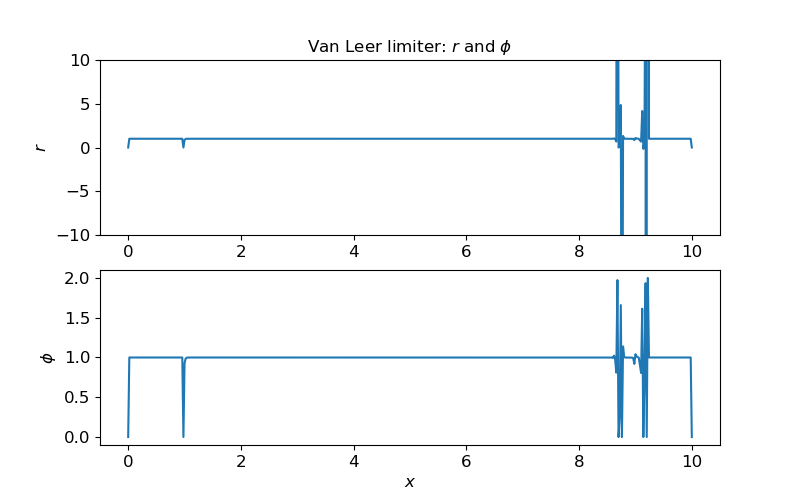

In [9]:
plt.figure()
plt.subplot(211)
plt.plot(x,r)
plt.ylabel(r'$r$')
plt.ylim(-10,10)
plt.title('Van Leer limiter: $r$ and $\phi$')

plt.subplot(212)
plt.plot(x,phi)
plt.xlabel(r'$x$')
plt.ylabel(r'$\phi$')
plt.show()